## ASTR 597A Homework 3
Eric Bellm

Due Jan 24, 2023

Your name:
    
Your collaborators:

In [2]:
# Generic python packages
import numpy as np
import matplotlib.pyplot as plt

# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
import lsst.sphgeom
import lsst.geom as geom

afwDisplay.setDefaultBackend('matplotlib')

# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)

In [7]:
butler = dafButler.Butler('dp02', collections='2.2i/runs/DP0.2')
registry = butler.registry

### Exercise 1a

How many DP0.2 tracts have r-band `'deepCoadd'`s?

## Exercise 2: DIY Good-seeing Coadd

Complete the `09a_Custom_Coadd` tutorial notebook, but rather than coadding all of the visits within a temporal window, instead coadd the three first three visits that have seeing values in the range included in the `goodSeeingCoadd` inputs.  Display the result and compare to the standard `deepCoadd` and `goodSeeingCoadd`.

Coadded template images are a necessary input to alert production.  What are the implications of this exercise for alert generation early in the LSST survey?  How many images were taken before three images had good enough seeing?  How long did the survey run before the images were acquired?

In [8]:
%%time

my_ra_deg = 55.745834
my_dec_deg = -32.269167
my_filter = 'i'

my_spherePoint = lsst.geom.SpherePoint(my_ra_deg*lsst.geom.degrees, my_dec_deg*lsst.geom.degrees)

skymap = butler.get('skyMap')
tract = skymap.findTract(my_spherePoint)
my_tract = tract.tract_id
my_patch = tract.findPatch(my_spherePoint).getSequentialIndex()
print('My tract and patch: ', my_tract, my_patch)

my_dataId = {'band': my_filter, 'tract': my_tract, 'patch': my_patch}
my_deepCoadd = butler.get('deepCoadd', dataId=my_dataId)

del my_ra_deg, my_dec_deg, my_filter, my_spherePoint, skymap, tract

My tract and patch:  4431 17
CPU times: user 2.92 s, sys: 962 ms, total: 3.89 s
Wall time: 4.32 s


In [9]:
visitTableRef = list(butler.registry.queryDatasets('visitTable'))
visitTable = butler.get(visitTableRef[0])

In [10]:
my_coadd_inputs = my_deepCoadd.getInfo().getCoaddInputs().visits.asAstropy().to_pandas()
good_coadd_inputs = butler.get('goodSeeingCoadd', dataId=my_dataId)
good_coadd_inputs = good_coadd_inputs.getInfo().getCoaddInputs().visits.asAstropy().to_pandas()

In [11]:
my_coadd_inputs.set_index('id', inplace=True)
good_coadd_inputs.set_index('id', inplace=True)

my_coadd_inputs['mjd'] = visitTable.loc[my_coadd_inputs.index]['expMidptMJD']
good_coadd_inputs['mjd'] = visitTable.loc[good_coadd_inputs.index]['expMidptMJD']

first3 = good_coadd_inputs.sort_values('mjd').iloc[:3]

In [12]:
time_needed = my_coadd_inputs.query(f"mjd <= {first3.iloc[-1]['mjd']}")

In [13]:
my_visits_tupleString = "("+",".join(first3.index.astype(str))+")"
print(my_visits_tupleString)

(174602,177422,192350)


In [14]:
import getpass


In [15]:
my_username = getpass.getuser()
print(my_username)

ykwang1


In [16]:
my_collection_identifier = 'custom_coadd_window1_test1'
print(my_collection_identifier)

custom_coadd_window1_test1


In [17]:
my_outputCollection = 'u/'+my_username+'/'+my_collection_identifier
print('Name of new butler collection for my output: ', my_outputCollection)

Name of new butler collection for my output:  u/ykwang1/custom_coadd_window1_test1


In [18]:
for c in sorted(butler.registry.queryCollections()):
    if c.find(my_outputCollection) > -1:
        print(c)

u/ykwang1/custom_coadd_window1_test1
u/ykwang1/custom_coadd_window1_test1/20230120T000002Z
u/ykwang1/custom_coadd_window1_test1/20230120T201009Z
u/ykwang1/custom_coadd_window1_test1/20230120T223411Z


In [19]:
from lsst.ctrl.mpexec import SimplePipelineExecutor


In [20]:
simpleButler = SimplePipelineExecutor.prep_butler('dp02', inputs=['2.2i/runs/DP0.2'], output=my_outputCollection)

In [21]:
simpleButler.registry.getCollectionChain(my_outputCollection)


CollectionSearch(('u/ykwang1/custom_coadd_window1_test1/20230120T224308Z', '2.2i/runs/DP0.2'))

In [22]:
yaml_file = '$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-DP0.2.yaml'
steps = 'makeWarp,assembleCoadd'
my_uri = yaml_file + '#' + steps
print(my_uri)

$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-DP0.2.yaml#makeWarp,assembleCoadd


In [23]:
from lsst.pipe.base import Pipeline, Instrument

In [24]:
assembleCoaddPipeline = Pipeline.from_uri(my_uri)

In [25]:
assembleCoaddPipeline.addConfigOverride('makeWarp', 'doApplyFinalizedPsf', False)

In [26]:
queryString = f"tract = {my_tract} AND patch = {my_patch} AND " + \
              f"visit in {my_visits_tupleString} AND skymap = 'DC2'"

print(queryString)

tract = 4431 AND patch = 17 AND visit in (174602,177422,192350) AND skymap = 'DC2'


In [27]:
%%time
spe = SimplePipelineExecutor.from_pipeline(assembleCoaddPipeline, where=queryString, butler=simpleButler)

CPU times: user 731 ms, sys: 114 ms, total: 845 ms
Wall time: 15min 47s


In [28]:
%%time
quanta = spe.run()

CPU times: user 5min 1s, sys: 14 s, total: 5min 15s
Wall time: 5min 36s


In [29]:
for q, quantum in enumerate(quanta):
    print(q, quantum.taskName)

0 lsst.pipe.tasks.makeWarp.MakeWarpTask
1 lsst.pipe.tasks.makeWarp.MakeWarpTask
2 lsst.pipe.tasks.makeWarp.MakeWarpTask
3 lsst.pipe.tasks.assembleCoadd.CompareWarpAssembleCoaddTask


In [32]:
coadd_index = 3

In [33]:
my_new_deepCoadd = simpleButler.get(quanta[coadd_index].outputs['deepCoadd'][0])

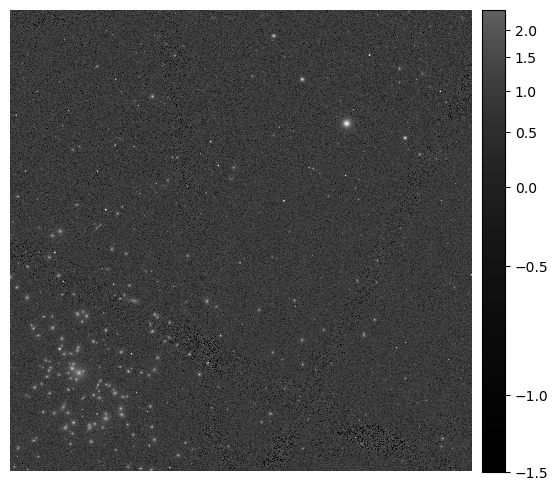

In [36]:
fig = plt.figure(figsize=(10, 6))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_new_deepCoadd.image)
plt.gca().axis('off')
plt.savefig('/home/ykwang1/WORK/astr597-survey-science/data/coadd_3_good_seeing.png')